В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle) Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [77]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
train_df = pd.read_csv("drive/MyDrive/1. ML/Модуль 2/Дані для задачі класифікації/train.csv")

In [8]:
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [36]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9600 entries, 7611 to 8106
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               9600 non-null   int64  
 1   CustomerId       9600 non-null   float64
 2   Surname          9600 non-null   object 
 3   CreditScore      9600 non-null   float64
 4   Geography        9600 non-null   object 
 5   Gender           9600 non-null   object 
 6   Age              9600 non-null   float64
 7   Tenure           9600 non-null   float64
 8   Balance          9600 non-null   float64
 9   NumOfProducts    9600 non-null   float64
 10  HasCrCard        9600 non-null   float64
 11  IsActiveMember   9600 non-null   float64
 12  EstimatedSalary  9600 non-null   float64
 13  Exited           9600 non-null   float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.1+ MB


In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split


# Розбиваємо дані на train і validation з урахуванням stratify
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df['Exited']
)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")

Train size: 9600
Validation size: 2400


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [37]:
# Визначаємо цільову колонку та вхідні колонки
target_col = 'Exited'
input_cols = list(train_df.columns)[1:-1]

# Створюємо набори inputs і targets
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]

val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

print(train_inputs.shape, train_targets.shape)
print(val_inputs.shape, val_targets.shape)

(9600, 12) (9600,)
(2400, 12) (2400,)


3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [39]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [42]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from IPython.display import display

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9600 entries, 7611 to 8106
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               9600 non-null   int64  
 1   CustomerId       9600 non-null   float64
 2   Surname          9600 non-null   object 
 3   CreditScore      9600 non-null   float64
 4   Geography        9600 non-null   object 
 5   Gender           9600 non-null   object 
 6   Age              9600 non-null   float64
 7   Tenure           9600 non-null   float64
 8   Balance          9600 non-null   float64
 9   NumOfProducts    9600 non-null   float64
 10  HasCrCard        9600 non-null   float64
 11  IsActiveMember   9600 non-null   float64
 12  EstimatedSalary  9600 non-null   float64
 13  Exited           9600 non-null   float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.1+ MB


In [47]:
scaler = MinMaxScaler()

In [49]:
#Значення тепер у діапазоні [0, 1].
train_inputs[numeric_cols] = scaler.fit_transform(train_inputs[numeric_cols])

In [50]:
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

In [53]:
# One hot encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_inputs[categorical_cols]) #знаходимо унікальні значення в кожній категоріальній колонці.


OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [54]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [55]:
#перевірка нових колонок
print(encoded_cols)

['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']


In [57]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [58]:
#Числові колонки — відмасштабовані до [0, 1].
#Категоріальні колонки — замінені на one-hot колонки.
#Обидва датафрейми (train_inputs і val_inputs) тепер готові для подачі в модель.
#Валідаційні дані оброблені консистентно з тренувальними.

In [59]:
pd.set_option('display.max_columns', None)
display(train_inputs[:5], val_inputs[:5])

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7611,0.374702,France,Male,0.425926,0.2,0.000000,0.333333,0.0,0.0,114522.68,1.0,0.0,0.0,0.0,1.0
14633,0.651551,Germany,Female,0.407407,0.5,0.619614,0.000000,1.0,0.0,131768.98,0.0,1.0,0.0,1.0,0.0
8169,0.665871,France,Male,0.277778,0.3,0.000000,0.333333,0.0,1.0,103570.80,1.0,0.0,0.0,0.0,1.0
6609,0.517900,France,Female,0.351852,0.8,0.000000,0.333333,1.0,1.0,104469.08,1.0,0.0,0.0,1.0,0.0
7553,0.338902,France,Male,0.481481,0.3,0.000000,0.333333,1.0,1.0,171457.06,1.0,0.0,0.0,0.0,1.0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
6573,670.0,Germany,Male,43.0,5.0,141787.31,2.0,1.0,1.0,169291.70,0.0,1.0,0.0,0.0,1.0
8494,607.0,France,Male,39.0,9.0,0.00,1.0,1.0,1.0,94816.35,1.0,0.0,0.0,0.0,1.0
3054,559.0,France,Female,41.0,3.0,0.00,1.0,1.0,0.0,175743.92,1.0,0.0,0.0,1.0,0.0
11372,738.0,Spain,Female,32.0,2.0,0.00,2.0,1.0,1.0,67611.36,0.0,0.0,1.0,1.0,0.0
8048,562.0,France,Male,29.0,1.0,0.00,1.0,0.0,0.0,88838.14,1.0,0.0,0.0,0.0,1.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [60]:
import os
os.listdir()



train_inputs.to_parquet(os.path.join(save_dir, 'train_inputs.parquet'))
train_targets.to_frame().to_parquet(os.path.join(save_dir, 'train_targets.parquet'))
val_inputs.to_parquet(os.path.join(save_dir, 'val_inputs.parquet'))
val_targets.to_frame().to_parquet(os.path.join(save_dir, 'val_targets.parquet'))

print(os.listdir(save_dir))

['val_inputs.parquet', 'train_targets.parquet', 'train_inputs.parquet', 'val_targets.parquet']


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [61]:
from sklearn.linear_model import LogisticRegression

In [62]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]

In [64]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, roc_auc_score

def evaluate_model(model, inputs, targets, name='', threshold=0.5):
    """
    model - навчена модель
    inputs - датафрейм/матриця ознак
    targets - справжні мітки
    name - назва (для заголовків графіків)
    threshold - поріг для класифікації
    """
    # Ймовірності класу 1
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(inputs)[:, 1]
    else:
        # Для моделей без predict_proba
        probs = model.decision_function(inputs)
        probs = (probs - probs.min()) / (probs.max() - probs.min())

    # Перетворення на класи
    preds = (probs >= threshold).astype(int)

    # Метрики
    roc_auc = roc_auc_score(targets, probs)
    f1 = f1_score(targets, preds)

    print(f"{name} ROC AUC: {roc_auc:.4f}")
    print(f"{name} F1 Score: {f1:.4f}")

    #  Confusion Matrix
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure(figsize=(5, 4))
    sns.heatmap(cf, annot=True, fmt=".2f", cmap='Blues')
    plt.title(f'{name} Confusion Matrix (normalized)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    #  ROC Curve
    fpr, tpr, _ = roc_curve(targets, probs)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Train ROC AUC: 0.8629
Train F1 Score: 0.6139


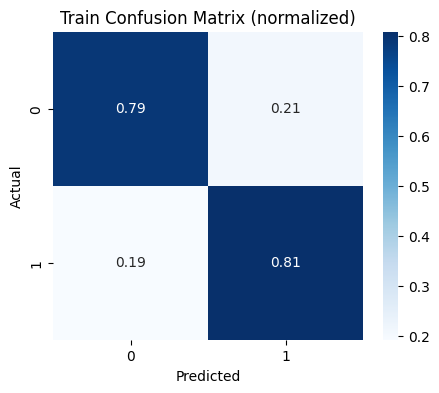

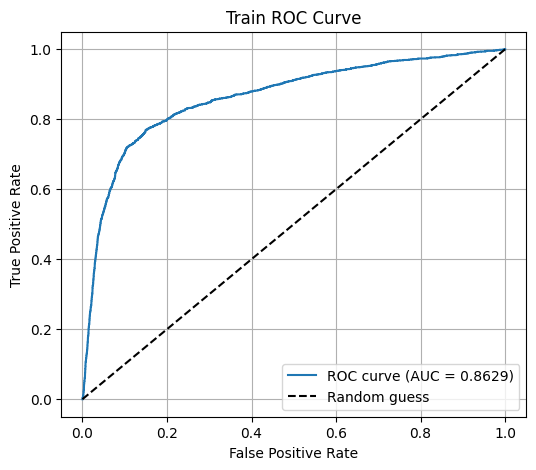

Validation ROC AUC: 0.8620
Validation F1 Score: 0.6260


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


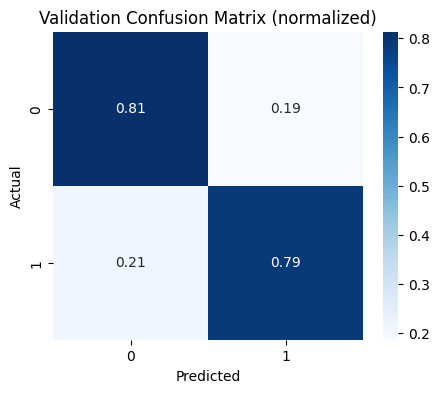

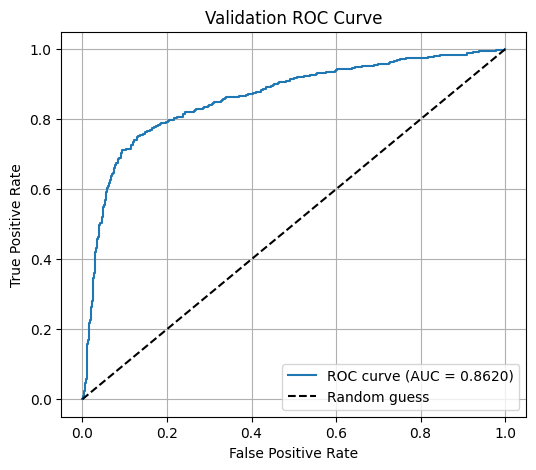

In [66]:
evaluate_model(model, train_inputs_processed, train_targets, name='Train')
evaluate_model(model, val_inputs_processed, val_targets, name='Validation')

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [73]:
from sklearn.metrics import accuracy_score

def evaluate_against_majority_baseline(model, X_train, y_train, X_val, y_val):
    """
    Порівнює модель із наївним бенчмарком (majority class).
    Виводить accuracy для обох.
    """
    # 1. Знаходимо мажоритарний клас на тренувальних даних
    majority_class = y_train.mode()[0]
    print(f"Majority class (in training): {majority_class}")

    # 2. Примітивна модель: прогнозує цей majority class
    train_preds_majority = [majority_class] * len(y_train)
    val_preds_majority = [majority_class] * len(y_val)

    acc_train_majority = accuracy_score(y_train, train_preds_majority)
    acc_val_majority = accuracy_score(y_val, val_preds_majority)

    print(f"Accuracy (Majority class model) - Train: {acc_train_majority:.4f}")
    print(f"Accuracy (Majority class model) - Validation: {acc_val_majority:.4f}")

    # 3. Прогнози реальної моделі
    train_preds_model = model.predict(X_train)
    val_preds_model = model.predict(X_val)

    acc_train_model = accuracy_score(y_train, train_preds_model)
    acc_val_model = accuracy_score(y_val, val_preds_model)

    print()
    print(f"Accuracy (Your model) - Train: {acc_train_model:.4f}")
    print(f"Accuracy (Your model) - Validation: {acc_val_model:.4f}")

In [74]:
evaluate_against_majority_baseline(model, X_train, train_targets, X_val, val_targets)

Majority class (in training): 0.0
Accuracy (Majority class model) - Train: 0.7965
Accuracy (Majority class model) - Validation: 0.7967

Accuracy (Your model) - Train: 0.8732
Accuracy (Your model) - Validation: 0.7963


Мажоритарна модель (постійний клас 0) дає accuracy 0.797 — це дуже непогано, але це просто наслідок дисбалансу класів (приблизно 80% класу 0).
Логістична регресія показує значно кращу точність — 0.87 на тренуванні і валідації. Це означає, що модель вміє вловлювати складніші патерни, а не просто вгадує найбільш поширений клас.
Відрив 7% по accuracy — це суттєво, особливо враховуючи, що модель також має гарний ROC AUC (0.88), тобто добре розрізняє класи.
Тобто модель робить корисні передбачення і дає реальну користь у порівнянні з простою стратегією.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [75]:
import joblib

objects_to_save = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

joblib.dump(objects_to_save, 'log_reg.joblib')

['log_reg.joblib']

In [76]:
model_2 = joblib.load('log_reg.joblib')

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [85]:
import warnings
warnings.filterwarnings("ignore")

def predict_train_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [87]:
predict_train_df(scaler, encoder, numeric_cols, categorical_cols, train_df[:5])

array([3.55073913e-100, 0.00000000e+000, 5.62659556e-179, 2.44254092e-139,
       4.75454559e-084])

Заповнення NaN — щоб модель не падала, якщо у нових даних пропуски
transform без side effects — ми не змінюємо сирий датафрейм inplace
DataFrame для one-hot — зберігаємо імена колонок від encoder
Правильний порядок колонок — критично для scikit-learn
Гнучкість — легко переюзати на будь-яких нових даних

In [88]:
print(scaler)
print(encoder)
print(numeric_cols)
print(categorical_cols)
print(input_cols)


MinMaxScaler()
OneHotEncoder(handle_unknown='ignore', sparse_output=False)
['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
['Geography', 'Gender']
['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [89]:
test_raw_df = pd.read_csv("drive/MyDrive/1. ML/Модуль 2/Дані для задачі класифікації/train.csv")

In [90]:
test_raw_df['Exited'] = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)

In [91]:
print(test_raw_df.head())

   id  CustomerId   Surname  CreditScore Geography  Gender   Age  Tenure  \
0   0  15779985.0   Nwankwo        678.0    France    Male  29.0     4.0   
1   1  15650086.0     Ch'in        687.0    France  Female  34.0     1.0   
2   2  15733602.0  Thompson        682.0    France  Female  52.0     6.0   
3   3  15645794.0   Macleod        753.0   Germany    Male  44.0     6.0   
4   4  15633840.0      Hsia        544.0   Germany  Female  55.0     0.0   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00            3.0        1.0             0.0        180626.36   
1       0.00            2.0        0.0             1.0         63736.17   
2       0.00            3.0        0.0             0.0        179655.87   
3   83347.25            2.0        1.0             0.0        161407.48   
4  107747.57            1.0        1.0             0.0        176580.86   

          Exited  Geography_France  Geography_Germany  Geography_Spain  \
0  2.393367e-181  

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [92]:
sample_submission = pd.read_csv('drive/MyDrive/1. ML/Модуль 2/Дані для задачі класифікації/sample_submission.csv')
print(sample_submission.head())

      id  Exited
0  15000     0.5
1  15001     0.5
2  15002     0.5
3  15003     0.5
4  15004     0.5


In [93]:
print(test_raw_df.head())

   id  CustomerId   Surname  CreditScore Geography  Gender   Age  Tenure  \
0   0  15779985.0   Nwankwo        678.0    France    Male  29.0     4.0   
1   1  15650086.0     Ch'in        687.0    France  Female  34.0     1.0   
2   2  15733602.0  Thompson        682.0    France  Female  52.0     6.0   
3   3  15645794.0   Macleod        753.0   Germany    Male  44.0     6.0   
4   4  15633840.0      Hsia        544.0   Germany  Female  55.0     0.0   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00            3.0        1.0             0.0        180626.36   
1       0.00            2.0        0.0             1.0         63736.17   
2       0.00            3.0        0.0             0.0        179655.87   
3   83347.25            2.0        1.0             0.0        161407.48   
4  107747.57            1.0        1.0             0.0        176580.86   

          Exited  Geography_France  Geography_Germany  Geography_Spain  \
0  2.393367e-181  

In [95]:
sample_submission['Exited'] = test_raw_df['Exited']

In [97]:
sample_submission.head()

,id,Exited
0,15000,2.393367e-181
1,15001,1.368466e-165
2,15002,5.847432e-101
3,15003,0.000000e+00
4,15004,0.000000e+00


In [98]:
sample_submission.to_csv('submission_log_reg.csv', index=False)

In [99]:
from google.colab import files
files.download('submission_log_reg.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>